In [328]:
import numpy as np
import pandas as pd
import datetime
from itertools import product
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
train = pd.read_csv('dataset/sales_train.csv')
test = pd.read_csv('dataset/test.csv')
shops = pd.read_csv('dataset/shops_translate.csv')
items = pd.read_csv('dataset/items.csv')
items_categories = pd.read_csv('dataset/items_categories_translate.csv')
submission = pd.read_csv('dataset/sample_submission.csv')

In [102]:
def preprocess_date(data):
    data.date = data.date.apply(lambda x : datetime.datetime.strptime(x, '%d.%m.%Y'))
    return data

# test if functions work
train = preprocess_date(train)
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [203]:
def groupby_dbn_shopid_item(data):
    month_sales = data.groupby(["date_block_num","shop_id","item_id"])["date","item_price","item_cnt_day"].agg({"date":["min","max"], "item_price":"mean", "item_cnt_day":"sum"})
    return month_sales

def create_timeseries(data):
    ts = data.groupby(["date_block_num"])["item_cnt_day"].sum()
    ts.astype('float')
    return ts

def create_revenue(data):
    data["revenue"] = data["item_cnt_day"] * data["item_price"]
    return data

def create_item_cnt_month(data):
    group = data.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
    group.columns = ['item_cnt_month']
    group.reset_index(inplace=True)
    return group

def lag_feature(data, lags, col):
    temp = data[["date_block_num","shop_id","item_id",col]]
    for i in lags:
        shift = temp.copy()
        shift.columns = ["date_block_num","shop_id","item_id",col+"_lag_"+str(i)]
        shift["date_block_num"] += i
        data = pd.merge(data, shift, on=["date_block_num", "shop_id", "item_id"], how="left")
    return data

def create_date_avg_item_cnt(data):
    group = data.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
    group.columns = [ 'date_avg_item_cnt' ]
    group.reset_index(inplace=True)
    return group

def create_date_item_avg_item_cnt(data):
    group = data.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
    group.columns = ['date_item_avg_item_cnt']
    group.reset_index(inplace=True)
    return group

def create_date_shop_avg_item_cnt(data):
    group = data.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
    group.columns = ['date_shop_avg_item_cnt']
    group.reset_index(inplace=True)
    return group

def create_date_category_item_cnt(data):
    group = data.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
    group.columns = ['date_cat_avg_item_cnt']
    group.reset_index(inplace=True)
    return group

def create_date_shop_category_avg_item_cnt(data):
    group = data.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
    group.columns = ['date_shop_cat_avg_item_cnt']
    group.reset_index(inplace=True)
    return group

def create_date_shop_type_avg_item_cnt(data):
    group = data.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
    group.columns = ['date_shop_type_avg_item_cnt']
    group.reset_index(inplace=True)
    return group

def create_date_shop_subtype_avg_item_cnt(data):
    group = data.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
    group.columns = ['date_shop_subtype_avg_item_cnt']
    group.reset_index(inplace=True)
    return group

def create_date_city_avg_item_cnt(data):
    group = data.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
    group.columns = ['date_city_avg_item_cnt']
    group.reset_index(inplace=True)
    return group

def create_date_item_city_avg_item_cnt(data):
    group = data.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
    group.columns = ['date_item_city_avg_item_cnt']
    group.reset_index(inplace=True)
    return group

def create_date_type_avg_item_cnt(data):
    group = data.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
    group.columns = ['date_type_avg_item_cnt']
    group.reset_index(inplace=True)
    return group

def create_date_subtype_avg_item_cnt(data):
    group = data.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
    group.columns = ['date_subtype_avg_item_cnt']
    group.reset_index(inplace=True)
    return group
# month_sales = groupby_dbn_shopid_item(train)
# print(month_sales.head())

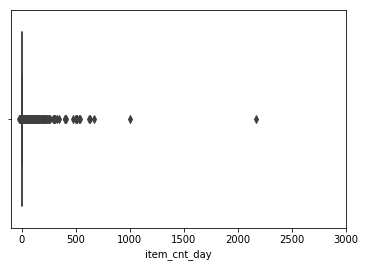

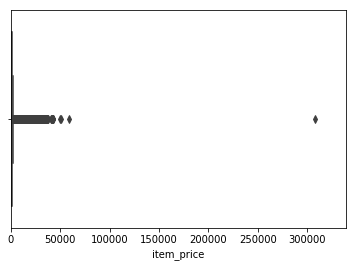

In [104]:
import seaborn as sns
plt.xlim(-100, 3000)
sns.boxplot(x=train["item_cnt_day"])
plt.show()

plt.xlim(train["item_price"].min(), train["item_price"].max() * 1.1)
sns.boxplot(x=train["item_price"])
plt.show()

In [105]:
train = train[train["item_price"] < 100000]
train = train[train["item_cnt_day"] < 1001]

In [106]:
median = train[(train["shop_id"]==32)&(train["item_id"]==2973)&(train["date_block_num"]==4)&(train["item_price"]>0)]["item_price"].median()
train.loc[train["item_price"] < 0,"item_price"] = median

In [107]:
# Change a shop's name to extract the city name easily
shops.loc[shops["shop_name"] == 'Sergiev Posad TC 7YA', 'shop_name'] = "SergievPosad TC 7YA"

In [108]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

In [110]:
items_categories['split'] = items_categories['item_category_name'].str.split('-')
items_categories['type'] = items_categories['split'].map(lambda x: x[0].strip())
items_categories['type_code'] = LabelEncoder().fit_transform(items_categories['type'])
items_categories['subtype'] = items_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
items_categories['subtype_code'] = LabelEncoder().fit_transform(items_categories['subtype'])
items_categories = items_categories[['item_category_id','type_code', 'subtype_code']]

In [111]:
# drop item's name
items.drop(['item_name'], axis=1, inplace=True)

In [113]:
def dataPreprocess(train, shops, items_categories, item):
    train = train[train["item_price"] < 100000]
    train = train[train["item_cnt_day"] < 1001]
    
    median = train[(train["shop_id"]==32)&(train["item_id"]==2973)&(train["date_block_num"]==4)&(train["item_price"]>0)]["item_price"].median()
    train.loc[train["item_price"] < 0,"item_price"] = median
    
    shops.loc[shops["shop_name"] == 'Sergiev Posad TC 7YA', 'shop_name'] = "SergievPosad TC 7YA"
    shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
    shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
    shops = shops[['shop_id','city_code']]
    
    items_categories['split'] = items_categories['item_category_name'].str.split('-')
    items_categories['type'] = items_categories['split'].map(lambda x: x[0].strip())
    items_categories['type_code'] = LabelEncoder().fit_transform(items_categories['type'])
    items_categories['subtype'] = items_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
    items_categories['subtype_code'] = LabelEncoder().fit_transform(items_categories['subtype'])
    items_categories = items_categories[['item_category_id','type_code', 'subtype_code']]
    items.drop(['item_name'], axis=1, inplace=True)
    
    return train, shops, items_categories, item

In [114]:
print(len(list(set(test["item_id"]) - set(test["item_id"]).intersection(set(train["item_id"])))))

363


In [210]:
data = []
cols = ["date_block_num","shop_id","item_id"]
for i in range(34):
    sales = train[train["date_block_num"] == i]
    data.append(np.array(list(product([i], sales["shop_id"].unique(), sales["item_id"].unique())), dtype="int16"))

In [211]:
data = pd.DataFrame(np.vstack(data),columns=cols)
data["date_block_num"] = data["date_block_num"].astype(np.int8)
data['shop_id'] = data['shop_id'].astype(np.int8)
data['item_id'] = data['item_id'].astype(np.int16)
data.sort_values(cols,inplace=True)

In [212]:
train = create_revenue(train)
group = create_item_cnt_month(train)
data = pd.merge(data, group, on=cols, how="left")
data["item_cnt_month"] = (data["item_cnt_month"].fillna(0).clip(0,20).astype(np.float16))

In [213]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [214]:
data = pd.concat([data, test], ignore_index = True, sort = False, keys = cols)
data.fillna(0, inplace = True)

In [215]:
data = pd.merge(data, shops, on="shop_id", how="left")
data = pd.merge(data, items, on="item_id", how="left")
data = pd.merge(data, items_categories, on="item_category_id", how="left")
data["city_code"] = data["city_code"].astype(np.int8)
data["item_category_id"] = data["item_category_id"].astype(np.int8)
data["type_code"] = data["type_code"].astype(np.int8)
data["subtype_code"] = data["subtype_code"].astype(np.int8)

In [216]:
data = lag_feature(data, [1,2,3,6,12],"item_cnt_month")

In [217]:
group = create_date_avg_item_cnt(data)
data = pd.merge(data, group, on="date_block_num", how="left")
data['date_avg_item_cnt'] = data['date_avg_item_cnt'].astype(np.float16)
data = lag_feature(data, [1], 'date_avg_item_cnt')
data.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [218]:
group = create_date_item_avg_item_cnt(data)
data = pd.merge(data, group, on=["date_block_num", "item_id"], how="left")
data['date_item_avg_item_cnt'] = data['date_item_avg_item_cnt'].astype(np.float16)
data = lag_feature(data, [1,2,3,6,12], 'date_item_avg_item_cnt')
data.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [219]:
group = create_date_shop_avg_item_cnt(data)
data = pd.merge(data, group, on=['date_block_num','shop_id'], how='left')
data['date_shop_avg_item_cnt'] = data['date_shop_avg_item_cnt'].astype(np.float16)
data = lag_feature(data, [1,2,3,6,12], 'date_shop_avg_item_cnt')
data.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [220]:
group = create_date_category_item_cnt(data)
data = pd.merge(data, group, on=['date_block_num','item_category_id'], how='left')

In [221]:
data['date_cat_avg_item_cnt'] = data['date_cat_avg_item_cnt'].astype(np.float16)
data = lag_feature(data, [1], 'date_cat_avg_item_cnt')
data.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [222]:
group = create_date_shop_category_avg_item_cnt(data)
data = pd.merge(data, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
data['date_shop_cat_avg_item_cnt'] = data['date_shop_cat_avg_item_cnt'].astype(np.float16)
data = lag_feature(data, [1], 'date_shop_cat_avg_item_cnt')
data.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [223]:
group = create_date_shop_type_avg_item_cnt(data)
data = pd.merge(data, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
data['date_shop_type_avg_item_cnt'] = data['date_shop_type_avg_item_cnt'].astype(np.float16)
data = lag_feature(data, [1], 'date_shop_type_avg_item_cnt')
data.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [224]:
group = create_date_shop_subtype_avg_item_cnt(data)
data = pd.merge(data, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
data['date_shop_subtype_avg_item_cnt'] = data['date_shop_subtype_avg_item_cnt'].astype(np.float16)
data = lag_feature(data, [1], 'date_shop_subtype_avg_item_cnt')
data.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [225]:
group = create_date_city_avg_item_cnt(data)
data = pd.merge(data, group, on=['date_block_num', 'city_code'], how='left')
data['date_city_avg_item_cnt'] = data['date_city_avg_item_cnt'].astype(np.float16)
data = lag_feature(data, [1], 'date_city_avg_item_cnt')
data.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [226]:
group = create_date_item_city_avg_item_cnt(data)
data = pd.merge(data, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
data['date_item_city_avg_item_cnt'] = data['date_item_city_avg_item_cnt'].astype(np.float16)
data = lag_feature(data, [1], 'date_item_city_avg_item_cnt')
data.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [227]:
group = create_date_type_avg_item_cnt(data)
data = pd.merge(data, group, on=['date_block_num', 'type_code'], how='left')
data['date_type_avg_item_cnt'] = data['date_type_avg_item_cnt'].astype(np.float16)
data = lag_feature(data, [1], 'date_type_avg_item_cnt')
data.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [228]:
group = create_date_subtype_avg_item_cnt(data)
data = pd.merge(data, group, on=['date_block_num', 'subtype_code'], how='left')
data['date_subtype_avg_item_cnt'] = data['date_subtype_avg_item_cnt'].astype(np.float16)
data = lag_feature(data, [1], 'date_subtype_avg_item_cnt')
data.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

In [229]:
def create_trend(train, data):
    group = train.groupby(['item_id']).agg({'item_price': ['mean']})
    group.columns = ['item_avg_item_price']
    group.reset_index(inplace=True)

    data = pd.merge(data, group, on=['item_id'], how='left')
    data['item_avg_item_price'] = data['item_avg_item_price'].astype(np.float16)

    group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
    group.columns = ['date_item_avg_item_price']
    group.reset_index(inplace=True)
    
    data = pd.merge(data, group, on=['date_block_num','item_id'], how='left')
    data['date_item_avg_item_price'] = data['date_item_avg_item_price'].astype(np.float16)
    
    data = lag_feature(data, [1,2,3,4,5,6], 'date_item_avg_item_price')
    
    for i in [1,2,3,4,5,6]:
        data['delta_price_lag_'+str(i)] = (data['date_item_avg_item_price_lag_'+str(i)] - data['item_avg_item_price']) / data['item_avg_item_price']
    
    def select_trend(row):
        for i in [1,2,3,4,5,6]:
            if row['delta_price_lag_'+str(i)]:
                return row['delta_price_lag_'+str(i)]
        return 0
    
    data['delta_price_lag'] = data.apply(select_trend, axis=1)
    data['delta_price_lag'] = data['delta_price_lag'].astype(np.float16)
    data['delta_price_lag'].fillna(0, inplace=True)
    
    fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
    for i in [1,2,3,4,5,6]:
        fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
        fetures_to_drop += ['delta_price_lag_'+str(i)]

    data.drop(fetures_to_drop, axis=1, inplace=True)
    return data

In [230]:
data = create_trend(train, data)

In [237]:
def create_last_month_revenue_trend(train, data):
    group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
    group.columns = ['date_shop_revenue']
    data.reset_index(inplace=True)

    data = pd.merge(data, group, on=['date_block_num','shop_id'], how='left')
    data['date_shop_revenue'] = data['date_shop_revenue'].astype(np.float32)

    data = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
    group.columns = ['shop_avg_revenue']
    group.reset_index(inplace=True)

    data = pd.merge(data, group, on=['shop_id'], how='left')
    data['shop_avg_revenue'] = data['shop_avg_revenue'].astype(np.float32)

    data['delta_revenue'] = (data['date_shop_revenue'] - data['shop_avg_revenue']) / data['shop_avg_revenue']
    data['delta_revenue'] = data['delta_revenue'].astype(np.float16)

    data = lag_feature(data, [1], 'delta_revenue')

    data.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
    return data

In [245]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

data = pd.merge(data, group, on=['date_block_num','shop_id'], how='left')
data['date_shop_revenue'] = data['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

data = pd.merge(data, group, on=['shop_id'], how='left')
data['shop_avg_revenue'] = data['shop_avg_revenue'].astype(np.float32)

data['delta_revenue'] = (data['date_shop_revenue'] - data['shop_avg_revenue']) / data['shop_avg_revenue']
data['delta_revenue'] = data['delta_revenue'].astype(np.float16)

data = lag_feature(data, [1], 'delta_revenue')

data.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [247]:
data["month"] = data["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
data["days"] = data["month"].map(days).astype(np.int8)

In [249]:
cache = {}
data['item_shop_last_sale'] = -1
data['item_shop_last_sale'] = data['item_shop_last_sale'].astype(np.int8)
for index, row in data.iterrows():    
    key = str(row["item_id"])+' '+str(row["shop_id"])
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row["date_block_num"]
    else:
        last_date_block_num = cache[key]
        data.at[index, 'item_shop_last_sale'] = row["date_block_num"] - last_date_block_num
        cache[key] = row["date_block_num"]

In [252]:
cache = {}
data['item_last_sale'] = -1
data['item_last_sale'] = data['item_last_sale'].astype(np.int8)
for index, row in data.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row["date_block_num"]
    else:
        last_date_block_num = cache[key]
        if row["date_block_num"] > last_date_block_num:
            data.at[index, 'item_last_sale'] = row["date_block_num"] - last_date_block_num
            cache[key] = row["date_block_num"]

In [253]:
data['item_shop_first_sale'] = data['date_block_num'] - data.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
data['item_first_sale'] = data['date_block_num'] - data.groupby('item_id')['date_block_num'].transform('min')

In [254]:
data = data[data["date_block_num"] > 11]

In [255]:
def fill_na(data):
    for col in data.columns:
        if ('_lag_' in col) & (data[col].isnull().any()):
            if ('item_cnt' in col):
                data[col].fillna(0, inplace=True)         
    return data

data = fill_na(data)

In [315]:
data.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4488710,12,2,27,0.0,0.0,0,19,8,46,0.0,...,1.034180,1.075195,-0.282715,1.211914,0,31,1,1,12,12
4488711,12,2,30,0.0,0.0,0,40,4,23,0.0,...,0.271484,0.291504,-0.483398,1.211914,0,31,1,1,11,11
4488712,12,2,31,0.0,0.0,0,37,4,10,0.0,...,0.271484,0.234009,-0.137451,1.211914,0,31,1,1,11,11
4488713,12,2,32,1.0,0.0,0,40,4,23,0.0,...,0.271484,0.291504,-0.407227,1.211914,0,31,-1,1,12,12
4488714,12,2,33,1.0,0.0,0,37,4,10,1.0,...,0.271484,0.234009,-0.225464,1.211914,0,31,1,1,12,12


In [292]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [262]:
model = XGBRegressor(max_depth = 8, n_estimators=1000, min_child_weight = 300, colsample_bytree = 0.8, subsample = 0.8, eta = 0.3, seed = 42)
model.fit(X_train, Y_train, eval_metric="rmse", eval_set=[(X_train,Y_train),(X_valid,Y_valid)], verbose=True, early_stopping_rounds=10)

C:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Anaconda\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.12488	validation_1-rmse:1.11846
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.08449	validation_1-rmse:1.08212
[2]	validation_0-rmse:1.05402	validation_1-rmse:1.05408
[3]	validation_0-rmse:1.01075	validation_1-rmse:1.02822
[4]	validation_0-rmse:0.982939	validation_1-rmse:1.00772
[5]	validation_0-rmse:0.963049	validation_1-rmse:0.991808
[6]	validation_0-rmse:0.942218	validation_1-rmse:0.975835
[7]	validation_0-rmse:0.924393	validation_1-rmse:0.963798
[8]	validation_0-rmse:0.909826	validation_1-rmse:0.954259
[9]	validation_0-rmse:0.898923	validation_1-rmse:0.946005
[10]	validation_0-rmse:0.888832	validation_1-rmse:0.939747
[11]	validation_0-rmse:0.880264	validation_1-rmse:0.933762
[12]	validation_0-rmse:0.873324	validation_1-rmse:0.929587
[13]	validation_0-rmse:0.867277	validation_1-rmse:0.926154
[14]	validation_0-rmse:0.862414	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=300, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

In [263]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)
submission = pd.DataFrame({"ID":test.index, "item_cnt_month":Y_test})
submission.to_csv("xgb_submission.csv", index=False)

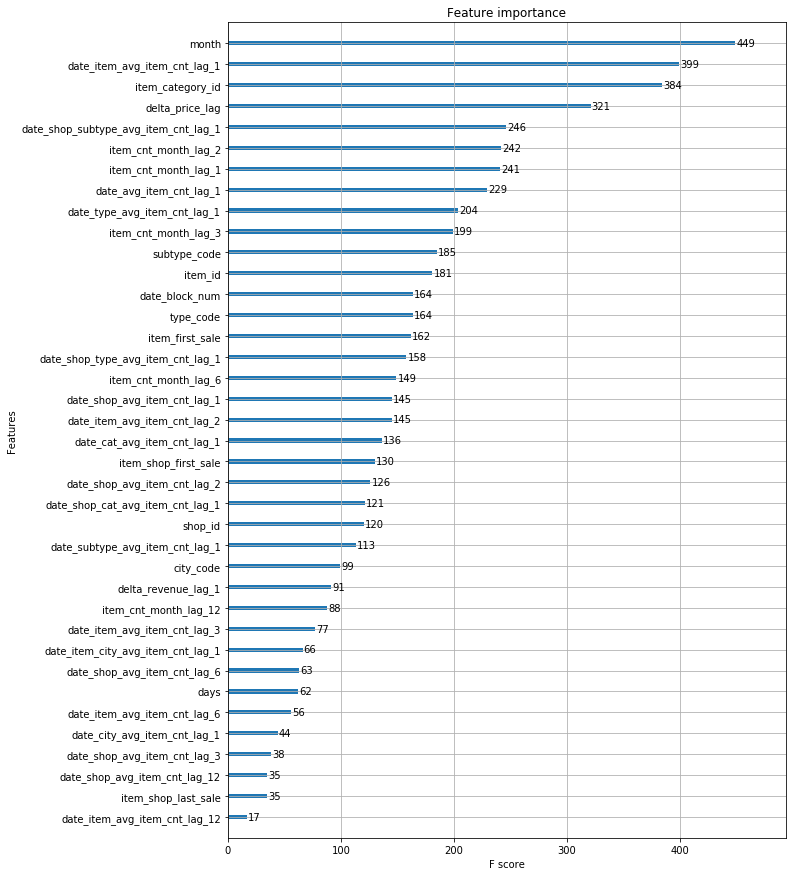

In [268]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model,[10,15])
plt.show()

In [312]:
X_train.fillna(0, inplace=True)

In [322]:
linearRegression = LinearRegression().fit(X_train, Y_train)

C:\Anaconda\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


In [326]:
X_valid.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [327]:
Y_pred = linearRegression.predict(X_valid).clip(0, 20)
Y_test = linearRegression.predict(X_test).clip(0, 20)
submission = pd.DataFrame({"ID":test.index, "item_cnt_month":Y_test})
submission.to_csv("lr_submission.csv", index=False)

In [329]:
rfr = RandomForestRegressor(max_depth=8,max_features=20,random_state=0).fit(X_train, Y_train)

C:\Anaconda\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


In [330]:
Y_pred = rfr.predict(X_valid).clip(0, 20)
Y_test = rfr.predict(X_test).clip(0, 20)
submission = pd.DataFrame({"ID":test.index, "item_cnt_month":Y_test})
submission.to_csv("rfr_submission.csv", index=False)

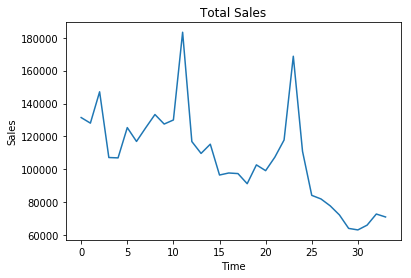

In [54]:
ts = create_timeseries(train)
plt.title("Total Sales")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(ts)
plt.show()

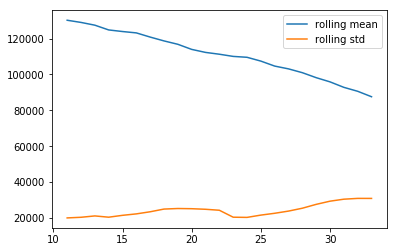

In [55]:
plt.plot(ts.rolling(window=12,center=False).mean(), label="rolling mean")
plt.plot(ts.rolling(window=12,center=False).std(), label="rolling std")
plt.legend()
plt.show()

In [56]:
# test stationarity 
def test_stationarity(ts):
    adf = adfuller(ts, autolag = "AIC")
    adfoutput = pd.Series(adf[0:4], index = ["Test Statistic", "p-value", "# of lags used", "Number of Obversation"])
    for key, value in adf[4].items():
        adfoutput["critical value (" + key + ")"] = value
    print(adfoutput)
test_stationarity(ts)

Test Statistic           -2.395704
p-value                   0.142953
# of lags used            0.000000
Number of Obversation    33.000000
critical value (1%)      -3.646135
critical value (5%)      -2.954127
critical value (10%)     -2.615968
dtype: float64


In [57]:
# Create differenced series
def difference(data, interval = 1):
    diff = []
    for i in range(interval, len(data)):
        val = data[i] - data[i - interval]
        diff.append(val)
    return pd.Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, val):
    return val + last_ob

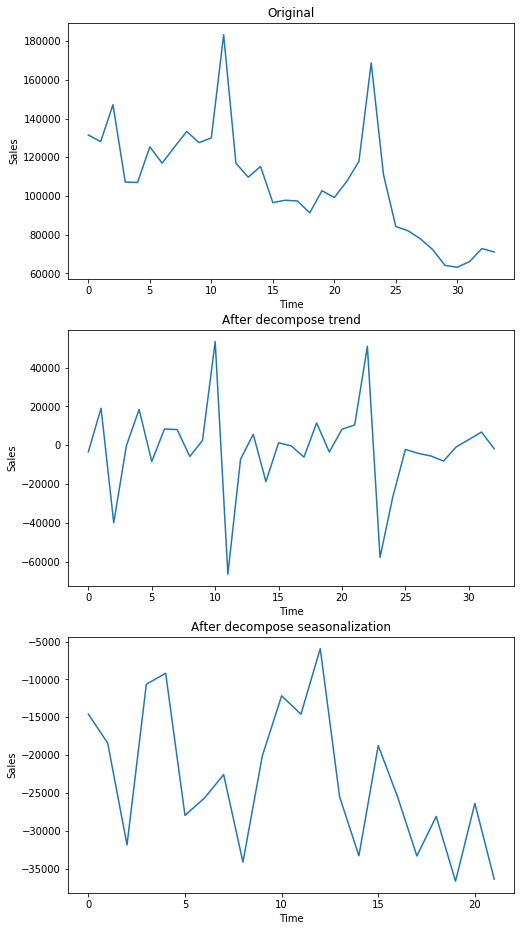

In [58]:
ts = create_timeseries(train)
plt.figure(figsize=(8, 16))
plt.subplot(311)
plt.title("Original")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(ts)

plt.subplot(312)
plt.title("After decompose trend")
plt.xlabel("Time")
plt.ylabel("Sales")
detrend_ts = difference(ts)
plt.plot(detrend_ts)
plt.plot()

plt.subplot(313)
plt.title("After decompose seasonalization")
plt.xlabel("Time")
plt.ylabel("Sales")
deseason_ts = difference(ts, 12)
plt.plot(deseason_ts)
plt.plot()
plt.show()

In [59]:
test_stationarity(deseason_ts)

Test Statistic           -3.270101
p-value                   0.016269
# of lags used            0.000000
Number of Obversation    21.000000
critical value (1%)      -3.788386
critical value (5%)      -3.013098
critical value (10%)     -2.646397
dtype: float64


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0096      1.052     -0.009      0.993      -2.072       2.053
ma.L1         -0.3216      1.061     -0.303      0.762      -2.402       1.759
ma.L2         -0.2579      0.488     -0.528      0.597      -1.215       0.699
sigma2      5.273e+08   4.44e-09   1.19e+17      0.000    5.27e+08    5.27e+08


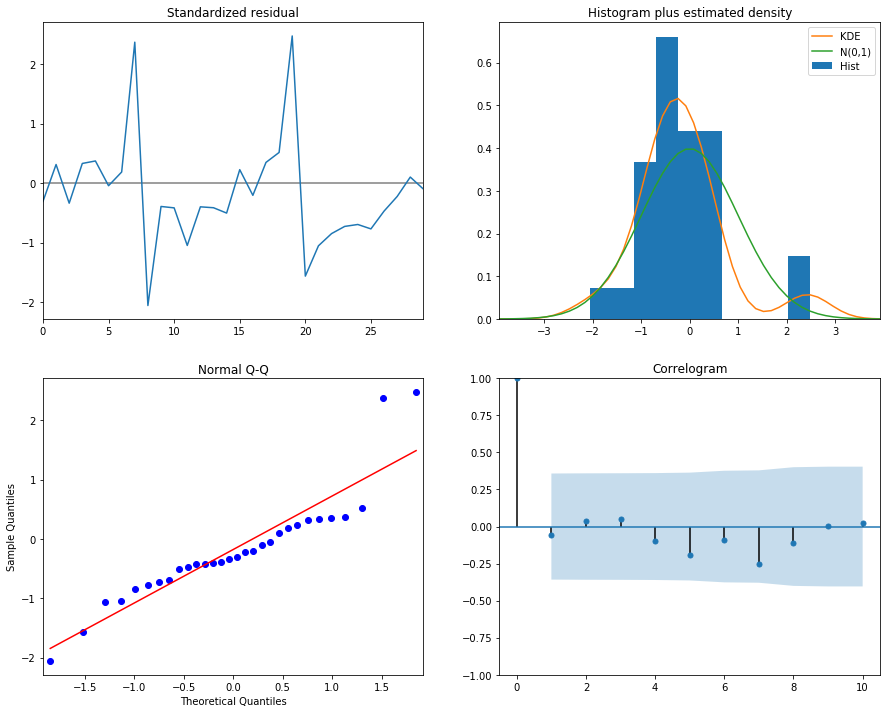

[71206.92502908 71797.68668068 71791.98999962 71792.04493239
 71792.04440268]


In [60]:
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def arima_predict(data):
    mod = sm.tsa.statespace.SARIMAX(data,
                                    order=(1, 1, 2),
                                    seasonal_order=(0, 0, 0, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    
    pred = results.get_prediction(10, dynamic=False)
    pred_ci = pred.conf_int()
    #print(pred_ci.shape)
    print((results.forecast(5)))
    return 

arima_predict(ts.tolist())

In [61]:
items_categories = pd.read_csv('dataset/items_categories_translate.csv')
items_categories.iloc[52,0] = "Book - Travel Guides"

In [62]:
train = pd.merge(train, items, on="item_id")
train = pd.merge(train, items_categories, on="item_category_id")
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Cinema - Blu-Ray
1,2013-01-23,0,24,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Cinema - Blu-Ray
2,2013-01-20,0,27,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Cinema - Blu-Ray
3,2013-01-02,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Cinema - Blu-Ray
4,2013-01-03,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Cinema - Blu-Ray


In [63]:
sales_by_category = train.groupby("item_category_name", as_index = False)["item_price"].sum().sort_values(by = "item_price")

In [64]:
sales_by_category.iloc[3,0] = "Books - Travel Guides"
sales_by_category.head()

,item_category_name,item_price
20,Books - Postcards,41.0
15,Books - Cognitive Literature,129.0
63,PC - Headsets / Headphones,263.4
9,Books - Travel Guides,300.0
0,Accessories - PS2,431.0


In [65]:
sales_by_category["item_category"] = sales_by_category.item_category_name.str.extract('([A-Za-z\ ]+)', expand=False) 
sales_by_category.head()

,item_category_name,item_price,item_category
20,Books - Postcards,41.0,Books
15,Books - Cognitive Literature,129.0,Books
63,PC - Headsets / Headphones,263.4,PC
9,Books - Travel Guides,300.0,Books
0,Accessories - PS2,431.0,Accessories


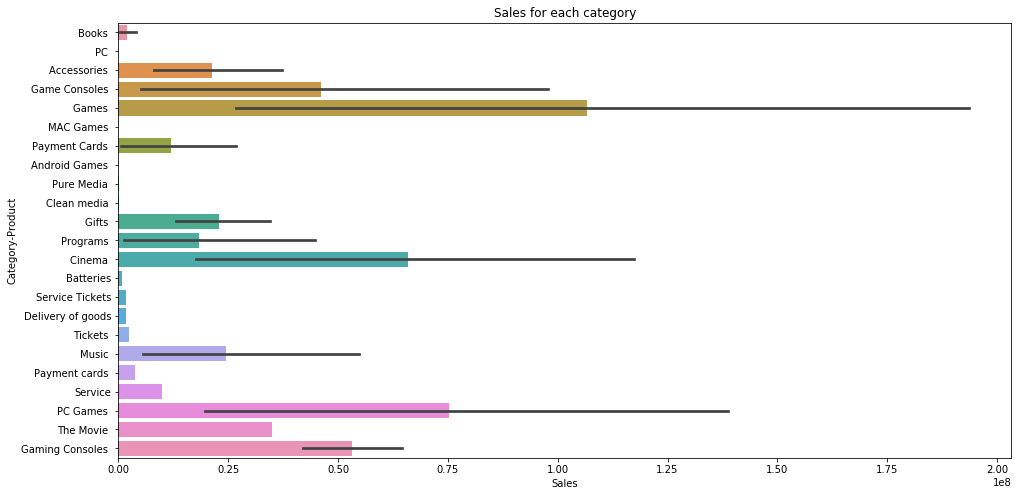

In [66]:
plt.figure(figsize = (16,8))
sns.barplot(y = "item_category", x = "item_price", data = sales_by_category)
plt.title("Sales for each category")
plt.xlabel("Sales")
plt.ylabel("Category-Product")
plt.show()